# Inference example of timbre transfer with dual latent diffusion bridge

Add the main tssb folder to the system path, or navigate (cd) to that directory to ensure modules can be imported correctly.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from main.module_base_latent_cond import (
    Model, 
    AudioDiffusionModel,
)


from audio_diffusion_pytorch import (
    KarrasSamplerReverse, 
    KarrasSampler,
    KarrasSampler_grad_guided,
    KarrasSchedule,
    KDistribution,
    # PitchTracker,
    NormalizedEncodec,
    plot_spec, 
    play_audio
)
import torch
import torchaudio
from IPython.display import HTML
from typing import Dict, Any
from torchaudio.prototype.transforms import ChromaSpectrogram
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Distribution, Schedule, and Samplers

- **`sigma_min`**, **`sigma_max`**, and **`rho`** will define the **`diffusion_sigma_distribution`**, creating a distribution of sigmas following **Formula 1** from the reference paper.

- **`diffusion_schedule`** follows the Karras scheduling algorithm to manage the progression of sigma values during the diffusion process.

The following samplers implement the Karras sampling algorithm:
- **`diffusion_sampler_reverse`**: Handles the reverse diffusion process (adding noise to audio).
- **`diffusion_sampler`**: Handles the forward diffusion process (denoising from noise).



In [2]:
sigma_min = 0.001
sigma_max = 100
rho = 9.0

diffusion_sigma_distribution = KDistribution(sigma_min = sigma_min, sigma_max = sigma_min, rho = rho)
diffusion_schedule = KarrasSchedule(sigma_min=sigma_min, sigma_max=sigma_max, rho=rho)  

diffusion_sampler_reverse = KarrasSamplerReverse()
diffusion_sampler = KarrasSampler()

## Creating and Loading the Diffusion and PyTorch Lightning Models

In [3]:
# Loading violin model
diffusion_model_violin = AudioDiffusionModel(
    diffusion_sigma_distribution =  diffusion_sigma_distribution,
)

violin_mean_path  = '/workspace/data/kinwai/diffusion-timbre-transfer/ckpts/mean_tensor_enc_violin.pt'
violin_std_path = '/workspace/data/kinwai/diffusion-timbre-transfer/ckpts/std_tensor_enc_violin.pt'
violin_model_weights = '/workspace/data/kinwai/diffusion-timbre-transfer/ckpts/violin.ckpt'

# Pytorch lighting model
pl_model_violin = Model(
    model = diffusion_model_violin,
    mean_path = violin_mean_path,
    std_path = violin_std_path,
)

ckpt_violin = torch.load(violin_model_weights, map_location=device)    
pl_model_violin.load_state_dict(ckpt_violin["state_dict"], strict=True)
pl_model_violin.to(device)

Model(
  (encodec_model): EncodecModel(
    (encoder): EncodecEncoder(
      (layers): ModuleList(
        (0): EncodecConv1d(
          (conv): Conv1d(1, 32, kernel_size=(7,), stride=(1,))
        )
        (1): EncodecResnetBlock(
          (block): ModuleList(
            (0): ELU(alpha=1.0)
            (1): EncodecConv1d(
              (conv): Conv1d(32, 16, kernel_size=(3,), stride=(1,))
            )
            (2): ELU(alpha=1.0)
            (3): EncodecConv1d(
              (conv): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
            )
          )
          (shortcut): EncodecConv1d(
            (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
          )
        )
        (2): ELU(alpha=1.0)
        (3): EncodecConv1d(
          (conv): Conv1d(32, 64, kernel_size=(4,), stride=(2,))
        )
        (4): EncodecResnetBlock(
          (block): ModuleList(
            (0): ELU(alpha=1.0)
            (1): EncodecConv1d(
              (conv): Conv1d(64, 32, kernel_size=

## Loading Audio and Converting to Encodec Embeddings

Input waveform shape: torch.Size([1, 1, 409600])


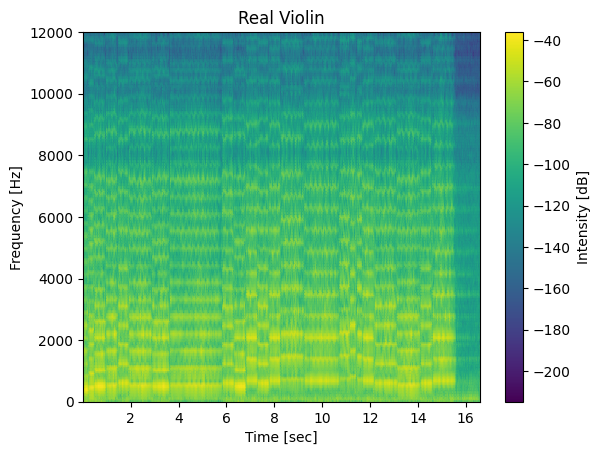

Input Encodec embeddings shape: torch.Size([1, 128, 1280])


In [4]:
sr = 24000
audio_path = '/workspace/data/kinwai/diffusion-timbre-transfer/audios/216001_1_violin.wav'
waveform_raw, orig_sr = torchaudio.load(audio_path)
resampler = torchaudio.transforms.Resample(orig_freq=orig_sr, new_freq=sr)
waveform_raw = resampler(waveform_raw)
waveform_ori = waveform_raw.unsqueeze(0)
waveform_ori = waveform_ori.to(device)

# Adjust the audio length to exactly 17 seconds with a sampling rate of 24,000 Hz, either by padding or cropping as needed.
pad_size = 409600 - waveform_ori.shape[-1] 
waveform_ori = torch.nn.functional.pad(waveform_ori, (0, pad_size))

print(f'Input waveform shape: {waveform_ori.shape}')
plot_spec(waveform_raw.numpy(), sr, title='Real Violin')
play_audio(waveform_raw.numpy(), sr)

# Conver the input audio to encodec embeddings
encodec = NormalizedEncodec(device=device)
embeddings_violin = encodec.encode_latent(waveform_ori, pl_model_violin.mean, pl_model_violin.std)
print(f'Input Encodec embeddings shape: {embeddings_violin.shape}')


## Noise adding

### Apply noise to the input audio using violin model, progressing through the forward diffusion steps to transform it into the shared latent space representation.

In [5]:
num_steps = 100
# Convert to Noise
noisy_violin_embeddings = pl_model_violin.model.sample(
    noise=embeddings_violin,
    sampler=diffusion_sampler_reverse,
    sigma_schedule=diffusion_schedule,
    num_steps=num_steps
)

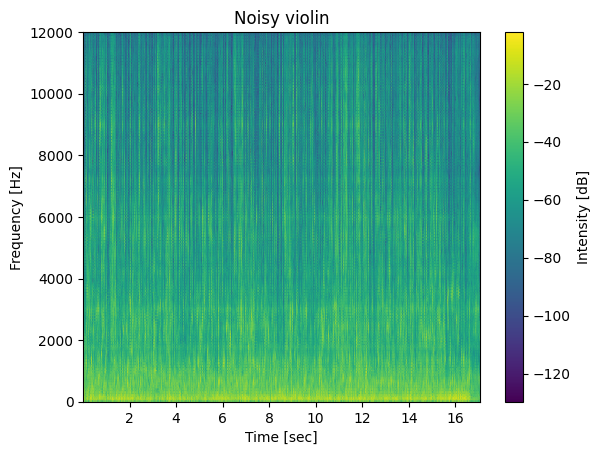

In [6]:
noise_waveform = encodec.decode_latent(noisy_violin_embeddings, pl_model_violin.mean, pl_model_violin.std)
noise_waveform = noise_waveform.cpu().detach().squeeze(0).numpy()
plot_spec(noise_waveform, sr, title='Noisy violin')
play_audio(noise_waveform, sr)

# gradient test

In [14]:
x = torch.randn(1,128,1024).to(device)
x_in = x.requires_grad_(True)
encodec.train()
x_chroma = encodec.decode_latent(x_in, pl_model_violin.mean, pl_model_violin.std)   
y = x_chroma * 2
loss = torch.functional.F.mse_loss(x_chroma, y)

AttributeError: 'NormalizedEncodec' object has no attribute 'train'

In [11]:
grad = torch.autograd.grad(loss, x_in)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
x_chroma.shape

torch.Size([1, 1, 327680])

In [13]:
x_chroma.requires_grad

False

## Using control function

In [6]:
# define control functions f
# need to pass the reference condition

f_chroma = ChromaSpectrogram(sample_rate=sr, n_fft=2048).to(device)
diffusion_sampler_grad_guided = KarrasSampler_grad_guided(
    f=f_chroma,
    c=waveform_ori, # need to be in raw waveform
    encodec=encodec,
    mean=pl_model_violin.mean,
    std=pl_model_violin.std
    )
generated_violin_embeddings = pl_model_violin.model.sample(
    noise=noisy_violin_embeddings,
    sampler=diffusion_sampler_grad_guided,
    sigma_schedule=diffusion_schedule,
    num_steps=num_steps
)

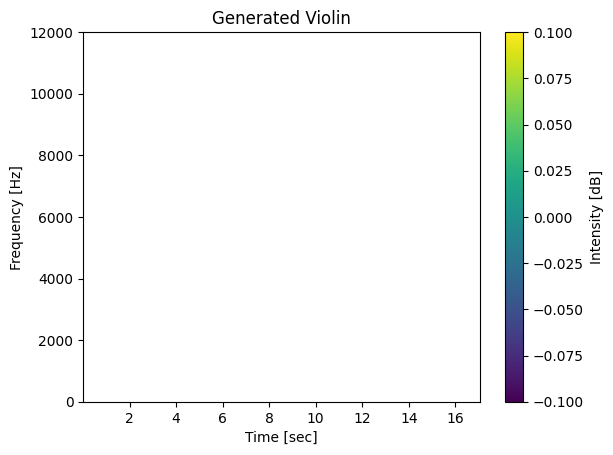

In [7]:
waveform_recon = encodec.decode_latent(generated_violin_embeddings, pl_model_violin.mean, pl_model_violin.std)
waveform_recon = waveform_recon.cpu().detach().squeeze(0).numpy()
plot_spec(waveform_recon, sr, title='Generated Violin')
play_audio(waveform_recon, sr)

### Old: Use the violin model to denoise from the latent space, obtaining a corresponding point in the violin-specific space that matches the shared latent space representation.

In [ ]:
generated_violin_embeddings = pl_model_violin.model.sample(
    noise=noisy_violin_embeddings,
    sampler=diffusion_sampler,
    sigma_schedule=diffusion_schedule,
    num_steps=num_steps
)

In [ ]:
waveform_recon = encodec.decode_latent(generated_violin_embeddings, pl_model_violin.mean, pl_model_violin.std)
waveform_recon = waveform_recon.cpu().detach().squeeze(0).numpy()
plot_spec(waveform_recon, sr, title='Generated Violin')
play_audio(waveform_recon, sr)

In [ ]:
chroma_ori = f_chroma(waveform_ori.to(device).squeeze(0))
chroma_recon = f_chroma(torch.tensor(waveform_recon).to(device))

In [ ]:
chroma_ori.shape

In [ ]:
# imshow both chroma_recon and chroma_ori in a subplot, top and bottom
# using fig, ax = plt.subplots(2, 1)
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].imshow(chroma_ori[0].cpu().numpy(), aspect='auto', origin='lower')
ax[0].set_title('Original Chroma')
ax[1].imshow(chroma_recon[0].cpu().numpy(), aspect='auto', origin='lower')
ax[1].set_title('Generated Chroma')
# increase the space between the two subplots
plt.tight_layout()
plt.show()